## Import packages

In [1]:
import sys
sys.path.append('../scripts')

import argparse
import gensim
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models.callbacks import PerplexityMetric
from gensim.models.wrappers import LdaMallet
import glob
import lxml.etree
import matplotlib.pyplot as plt
import nltk
from nltk import FreqDist
import numpy as np
import os
import pandas as pd

import seaborn as sns
plt.style.use('seaborn-whitegrid')

from utils import is_punct

TOKENIZER = nltk.tokenize.word_tokenize

In [2]:
import logging

logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

## Corpus characteristics

### Calculate normalized corpus size

In [112]:
os.chdir("/Users/alielassche/documents/github/songs-popular-topics/Corpus/txt-timeset")
words = []

for doc in glob.glob("*.txt"):
    text = open(doc, "r", encoding="utf-8").read()
    for sentence in TOKENIZER(text, language="dutch"):
        words.extend([w.lower() for w in sentence.split() if not is_punct(w)])

fd = FreqDist(words)

In [113]:
print(len(words))
print(len(fd))

6603636
217906


In [114]:
os.chdir("/Users/alielassche/documents/github/songs-popular-topics/corpus/VARDnormalized/varded50")
words_norm = []

for doc in glob.glob("*.txt"):
    text = open(doc, "r", encoding="utf-8").read()
    for sentence in TOKENIZER(text, language="dutch"):
        words_norm.extend([w.lower() for w in sentence.split() if not is_punct(w)])

fd_norm = FreqDist(words_norm)

In [115]:
print(len(words_norm))
print(len(fd_norm))

6615537
194049


### Calculate genres and song lengths

In [17]:
songs = pd.read_csv('../data/songs_2022.csv', sep='\t', index_col=0)
songs.shape

(29590, 7)

In [18]:
songs_timeset = songs[(songs['year'] >= 1550) & (songs['year'] <= 1750)]
songs_timeset.shape

(22297, 7)

In [20]:
songs_timeset.groupby('category')['id'].count().sort_values(ascending=False)

category
None                         7017
religion                     6914
love and sex                 3261
seasons and annual events    1033
formal genres                 818
amusement                     722
emotions                      694
narratives                    479
cycle of life                 473
politics and history          300
groups                        187
children                      148
occasions                     100
theatre                        90
work                           59
miscellaneous                   2
Name: id, dtype: int64

In [103]:
songs_timeset.mean()

id         77269.256985
year        1653.673588
n_words      296.167018
dtype: float64

In [60]:
songs_timeset.groupby('category')['n_words'].mean()

category
None                         299.546102
amusement                    251.102493
children                     221.040541
cycle of life                223.196617
emotions                     322.913545
formal genres                334.311736
groups                       223.427807
love and sex                 219.984667
miscellaneous                 91.000000
narratives                   363.066806
occasions                    277.420000
politics and history         478.203333
religion                     323.194388
seasons and annual events    295.959342
theatre                      206.533333
work                         360.084746
Name: n_words, dtype: float64

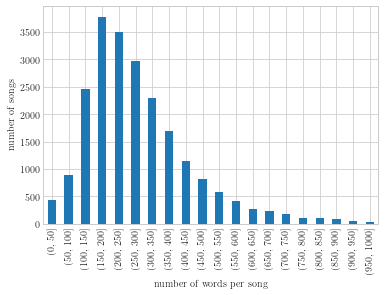

In [62]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
songs_timeset.groupby(pd.cut(songs_timeset["n_words"], np.arange(0, 1050, 50)))['n_words'].count().plot(kind='bar')
plt.xlabel('number of words per song')
plt.ylabel('number of songs')
plt.show()

In [98]:
religion = songs_timeset.loc[songs_timeset['category'] == 'religion']
love = songs_timeset.loc[songs_timeset['category'] == 'love and sex']
none = songs_timeset.loc[songs_timeset['category'] == 'None']
seasons = songs_timeset.loc[songs_timeset['category'] == 'seasons and annual events']
politics = songs_timeset.loc[songs_timeset['category'] =='politics and history']
formal = songs_timeset.loc[songs_timeset['category'] == 'formal genres']
amusement = songs_timeset.loc[songs_timeset['category'] == 'amusement']
emotions = songs_timeset.loc[songs_timeset['category'] == 'emotions']
narratives = songs_timeset.loc[songs_timeset['category'] == 'narratives']
cycle = songs_timeset.loc[songs_timeset['category'] == 'cycle of life']
groups = songs_timeset.loc[songs_timeset['category'] == 'groups']
children = songs_timeset.loc[songs_timeset['category'] == 'children']

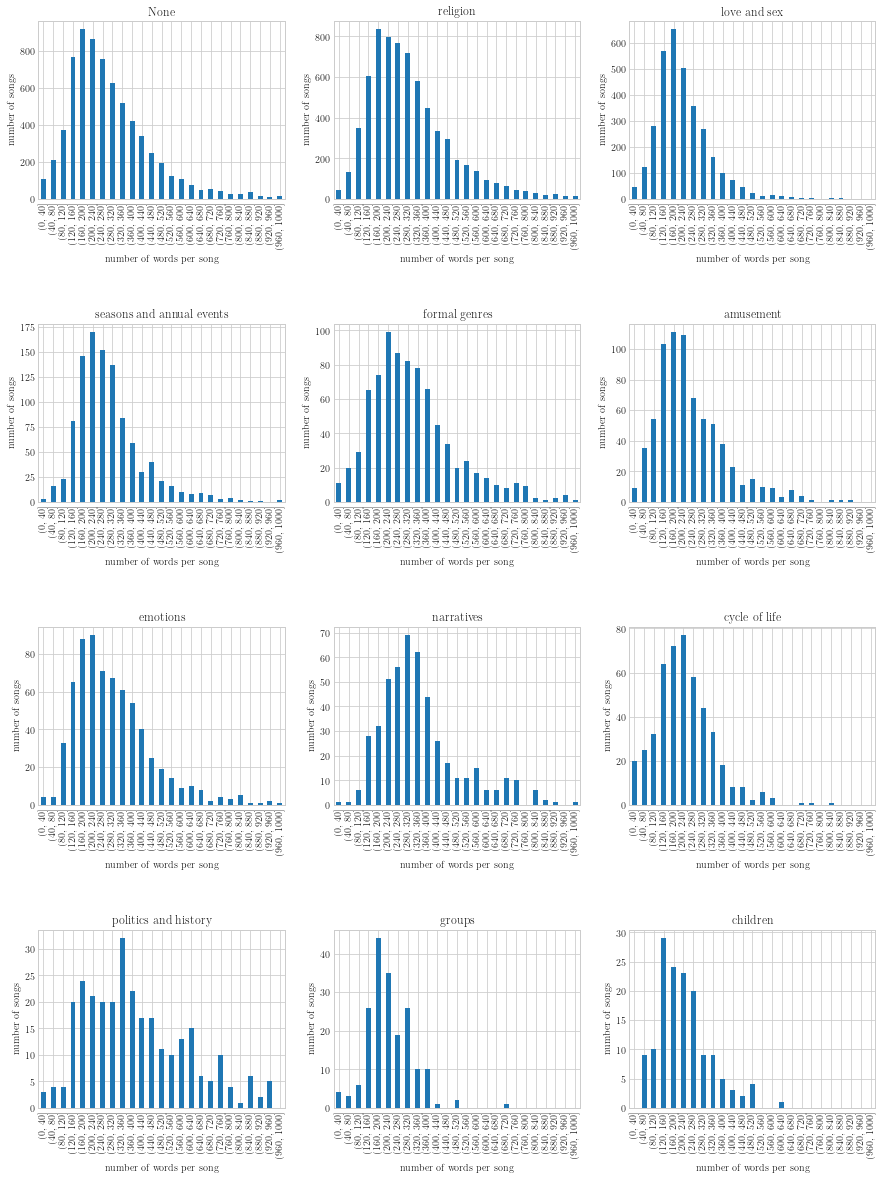

In [104]:
figs, (axes) = plt.subplots(4, 3, figsize=(15, 20), sharey=False)

ax1 = none.groupby(pd.cut(none["n_words"], np.arange(0, 1040, 40)))['n_words'].count().plot.bar(ax = axes[0,0])
ax1.set_title('None')
ax1.set_xlabel('number of words per song')
ax1.set_ylabel('number of songs')
x_axis.label.set_visible(False)

ax2 = religion.groupby(pd.cut(religion["n_words"], np.arange(0, 1040, 40)))['n_words'].count().plot.bar(ax = axes[0,1])
ax2.set_title('religion')
ax2.set_xlabel('number of words per song')
ax2.set_ylabel('number of songs')
x_axis.label.set_visible(False)

ax3 = love.groupby(pd.cut(love["n_words"], np.arange(0, 1040, 40)))['n_words'].count().plot.bar(ax = axes[0,2])
ax3.set_title('love and sex')
ax3.set_xlabel('number of words per song')
ax3.set_ylabel('number of songs')
x_axis.label.set_visible(False)

ax4 = seasons.groupby(pd.cut(seasons["n_words"], np.arange(0, 1040, 40)))['n_words'].count().plot.bar(ax = axes[1,0])
ax4.set_title('seasons and annual events')
ax4.set_xlabel('number of words per song')
ax4.set_ylabel('number of songs')
x_axis.label.set_visible(False)

ax5 = formal.groupby(pd.cut(formal["n_words"], np.arange(0, 1040, 40)))['n_words'].count().plot.bar(ax = axes[1,1])
ax5.set_title('formal genres')
ax5.set_xlabel('number of words per song')
ax5.set_ylabel('number of songs')
x_axis.label.set_visible(False)

ax6 = amusement.groupby(pd.cut(amusement["n_words"], np.arange(0, 1040, 40)))['n_words'].count().plot.bar(ax = axes[1,2])
ax6.set_title('amusement')
ax6.set_xlabel('number of words per song')
ax6.set_ylabel('number of songs')
x_axis.label.set_visible(False)

ax7 = emotions.groupby(pd.cut(emotions["n_words"], np.arange(0, 1040, 40)))['n_words'].count().plot.bar(ax = axes[2,0])
ax7.set_title('emotions')
ax7.set_xlabel('number of words per song')
ax7.set_ylabel('number of songs')
x_axis.label.set_visible(False)

ax8 = narratives.groupby(pd.cut(narratives["n_words"], np.arange(0, 1040, 40)))['n_words'].count().plot.bar(ax = axes[2,1])
ax8.set_title('narratives')
ax8.set_xlabel('number of words per song')
ax8.set_ylabel('number of songs')
x_axis.label.set_visible(False)

ax9 = cycle.groupby(pd.cut(cycle["n_words"], np.arange(0, 1040, 40)))['n_words'].count().plot.bar(ax = axes[2,2])
ax9.set_title('cycle of life')
ax9.set_xlabel('number of words per song')
ax9.set_ylabel('number of songs')
x_axis.label.set_visible(False)

ax10 = politics.groupby(pd.cut(politics["n_words"], np.arange(0, 1040, 40)))['n_words'].count().plot.bar(ax = axes[3,0])
ax10.set_title('politics and history')
ax10.set_xlabel('number of words per song')
ax10.set_ylabel('number of songs')
x_axis.label.set_visible(False)

ax11 = groups.groupby(pd.cut(groups["n_words"], np.arange(0, 1040, 40)))['n_words'].count().plot.bar(ax = axes[3,1])
ax11.set_title('groups')
ax11.set_xlabel('number of words per song')
ax11.set_ylabel('number of songs')
x_axis.label.set_visible(False)

ax12 = children.groupby(pd.cut(children["n_words"], np.arange(0, 1040, 40)))['n_words'].count().plot.bar(ax = axes[3,2])
ax12.set_title('children')
ax12.set_xlabel('number of words per song')
ax12.set_ylabel('number of songs')
x_axis.label.set_visible(False)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.7)
#plt.show()
plt.savefig('../plots/length-songs-genre.jpg', dpi=300, bbox_inches = "tight")

### Set timeperiod for corpus

In [7]:
nlb = pd.read_csv('../data/nlb.csv', sep=',')
nlb.shape

(203249, 6)

In [8]:
nlb_timeset = nlb[(nlb['jaar_begin'] >= 1550) & (nlb['jaar_begin'] <= 1750)]
nlb_timeset = nlb_timeset[nlb_timeset['incnormid'] != 0]

In [15]:
nlb_timeset.head()

,recordid,incnormid,bronid,w_g,herdrukid,jaar_begin
0,1,37966.0,1000604,wereldlijk,NaN,1643.0
1,2,36901.0,1000604,wereldlijk,NaN,1643.0
2,3,43989.0,1000604,wereldlijk,NaN,1643.0
3,4,38005.0,1000604,wereldlijk,NaN,1643.0
4,5,3505.0,1000604,wereldlijk,NaN,1643.0


## Load existing model

In [4]:
lda = LdaMallet.load('../topic_models/VARD2-TM')

INFO : loading LdaMallet object from ../topic_models/VARD2-TM
INFO : loading id2word recursively from ../topic_models/VARD2-TM.id2word.* with mmap=None
INFO : loaded ../topic_models/VARD2-TM


In [267]:
rows = []
for topic in range (0, 50):
    words = lda.show_topic(topic, 30)
    rows.append([str(topic), words])
keys = pd.DataFrame(rows, columns=['topic', 'words'])

In [276]:
keys.to_csv('../gensim_output/30_words_topics.csv', sep='\t')

In [281]:
lda.show_topic(31, 30)

[('gods', 0.021424578603371172),
 ('christus', 0.017404110767113862),
 ('god', 0.013372893016855866),
 ('woord', 0.009782421740626076),
 ('zullen', 0.009352425180598554),
 ('hoort', 0.00750343997248022),
 ('moeten', 0.006729446164430684),
 ('heren', 0.006256449948400413),
 ('och', 0.005632954936360509),
 ('vrienden', 0.005622205022359821),
 ('klaar', 0.005589955280357757),
 ('worden', 0.0049234606123151016),
 ('toch', 0.004869711042311662),
 ('alzo', 0.004482714138286894),
 ('horen', 0.004428964568283454),
 ('mensen', 0.00439671482628139),
 ('fijn', 0.0043859649122807015),
 ('geest', 0.00428921568627451),
 ('wereld', 0.004278465772273822),
 ('voort', 0.004170966632266942),
 ('waarheid', 0.003988218094255246),
 ('weg', 0.003977468180254558),
 ('broeders', 0.003923718610251118),
 ('zeid', 0.00391296869625043),
 ('paulus', 0.003891468868249054),
 ('woorden', 0.003869969040247678),
 ('vlees', 0.003816219470244238),
 ('mogen', 0.00375171998624011),
 ('komen', 0.0036334709322325422),
 ('wees

In [275]:
for topic in range (0,50):
    print(topic)
    print(lda.show_topic(topic, 30))

0
[('god', 0.03771437243891334), ('vader', 0.0180278819677818), ('geest', 0.0144613316566572), ('lof', 0.011523534895822042), ('leven', 0.010114259696897426), ('herten', 0.008531535242720552), ('onzen', 0.007729332437178848), ('woord', 0.007458317975847191), ('zonden', 0.007414955662034126), ('naam', 0.007393274505127593), ('loven', 0.00659107169958589), ('bidden', 0.006255013767534636), ('zijnen', 0.005745506580231121), ('recht', 0.005322724020553737), ('noot', 0.005311883442100471), ('heilig', 0.00522515881447434), ('genade', 0.00496498493159595), ('brood', 0.0048674197255165535), ('goedheid', 0.004802376254796956), ('hemel', 0.004748173362530625), ('rijk', 0.004639767577997962), ('prijs', 0.0046289269995446955), ('bereid', 0.004531361793465299), ('geven', 0.004422956008932636), ('ziel', 0.0043687531166663055), ('prijzen', 0.004292869067493442), ('allen', 0.004206144439867311), ('kracht', 0.004195303861414045), ('boven', 0.004162782126054246), ('helpt', 0.004032695184615051)]
1
[('ma

## Analyze the model

In [38]:
rows = []
for topic in range(0, 50):
    words = lda.show_topic(topic, 30)
    topic_n_words = ([word[1] for word in words])
    print('Topic {}: {}'.format(str(topic), topic_n_words))
    rows.append([str(topic), topic_n_words])
keys = pd.DataFrame(rows, columns=['topic', 'words'])
keys.head()

Topic 0: [0.03771437243891334, 0.0180278819677818, 0.0144613316566572, 0.011523534895822042, 0.010114259696897426, 0.008531535242720552, 0.007729332437178848, 0.007458317975847191, 0.007414955662034126, 0.007393274505127593, 0.00659107169958589, 0.006255013767534636, 0.005745506580231121, 0.005322724020553737, 0.005311883442100471, 0.00522515881447434, 0.00496498493159595, 0.0048674197255165535, 0.004802376254796956, 0.004748173362530625, 0.004639767577997962, 0.0046289269995446955, 0.004531361793465299, 0.004422956008932636, 0.0043687531166663055, 0.004292869067493442, 0.004206144439867311, 0.004195303861414045, 0.004162782126054246, 0.004032695184615051]
Topic 1: [0.017712958063996687, 0.015021508591934853, 0.014147362609555797, 0.014032343401348025, 0.013963331876423363, 0.011524924662418624, 0.010627774838398012, 0.009086517448413885, 0.008511421407375031, 0.00844240988245037, 0.007637275424995974, 0.0067861332842584715, 0.006648110234409146, 0.006625106392767592, 0.006487083342918

,topic,words
0,0,"[0.03771437243891334, 0.0180278819677818, 0.01..."
1,1,"[0.017712958063996687, 0.015021508591934853, 0..."
2,2,"[0.03406099460969538, 0.010243369567163912, 0...."
3,3,"[0.0291478352001048, 0.017990873561712625, 0.0..."
4,4,"[0.032109183107519215, 0.0149354250851755, 0.0..."


In [4]:
composition = pd.read_csv('../gensim_output/VARD2_topics.csv', sep='\t', index_col='id').drop(columns=['Unnamed: 0'])
composition.head()

,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,...,topic 40,topic 41,topic 42,topic 43,topic 44,topic 45,topic 46,topic 47,topic 48,topic 49
id,,,,,,,,,,,,,,,,,,,,,
186989,0.001133,0.000460,0.000571,0.001334,0.000532,0.000356,0.000333,0.167554,0.000240,0.000620,...,0.000428,0.000077,0.000629,0.000034,0.000330,0.000058,0.000728,0.000524,0.015967,0.000897
3644,0.000609,0.000247,0.081496,0.041311,0.000286,0.000191,0.000179,0.000706,0.633403,0.000333,...,0.000230,0.000041,0.000338,0.000018,0.000177,0.000031,0.008510,0.000282,0.000459,0.000482
38949,0.000580,0.038945,0.000292,0.008425,0.000272,0.000183,0.000170,0.000673,0.000123,0.000318,...,0.000219,0.000039,0.000322,0.000017,0.000169,0.000030,0.000373,0.000268,0.000438,0.000459
114233,0.091450,0.000276,0.000343,0.000801,0.463242,0.000214,0.000200,0.000789,0.000144,0.000373,...,0.000257,0.000046,0.000378,0.000020,0.000198,0.000035,0.000437,0.000315,0.254667,0.009615
19987,0.000727,0.000295,0.000366,0.000856,0.000341,0.000229,0.000213,0.000843,0.000154,0.000398,...,0.000274,0.000049,0.000403,0.978993,0.000212,0.000037,0.000467,0.000336,0.000548,0.000575


### Only take topics into account with weight above 0.1

In [5]:
maxVal = 0.1
new_composition = composition.where(composition >= maxVal, 0)

INFO : NumExpr defaulting to 4 threads.


In [205]:
new_composition.to_csv('new_composition.csv', sep='\t')

### Merge topics with corpus

In [9]:
new_msc = nlb_timeset.merge(new_composition, left_on='recordid', right_on='id')

In [10]:
new_incs = new_msc.groupby('incnormid').first().drop(columns=['recordid', 'bronid', 'w_g', 'herdrukid', 'jaar_begin'])

In [11]:
final_topics = nlb_timeset.set_index('incnormid').join(new_incs).sort_values('incnormid')

In [12]:
final_topics.shape

(72248, 55)

In [265]:
final_topics.to_csv('../gensim_output/dominant_topics_0.1_EMLC.csv', sep='\t')

In [3]:
check = pd.read_csv('../gensim_output/dominant_topics_0.1_EMLC.csv', sep='\t')

In [14]:
check.shape

(43772, 56)

In [18]:
check = check.rename(columns={'jaar_begin': 'year'})

/Users/alielassche/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


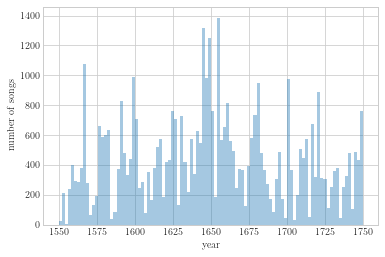

In [25]:
sns.distplot(check['year'], kde=False, bins=100)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.ylabel('number of songs')
plt.savefig('../plots/Figure1_100bins.jpg', bbox_inches='tight', dpi=300)

## Choose topic with highest contribution for each song

In [42]:
transformed_docs = lda.load_document_topics()
docs = [[texts[i]] + [r[0] for r in list(zip(max(row, key=lambda x:x[1])))] for i, row in enumerate(transformed_docs)]
dominant_topics = pd.DataFrame(docs, columns=['document_id', 'dominant_topic', 'perc_contribution'])

dominant_topics[['path', 'songid']] = dominant_topics.document_id.str.split('varded50/', expand=True)
dominant_topics = dominant_topics.drop(columns=['document_id', 'path'])
dominant_topics[['id', 'txt']] = dominant_topics.songid.str.split('.', expand=True)
dominant_topics = dominant_topics.drop(columns=['songid', 'txt'])
dominant_topics = dominant_topics[['id','dominant_topic','perc_contribution']]
#dominant_topics.to_csv('VARD2_dominant_topic_per_song_EMLC.csv', sep='\t')

FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/67164_doctopics.txt'

In [45]:
dominant_topics = pd.read_csv('../gensim_output/VARD2_dominant_topic_per_song.csv', sep='\t', index_col='id').drop(columns=['Unnamed: 0'])
dominant_topics.head()

,dominant_topic,perc_contribution
id,,
186989,38,0.318147
3644,8,0.633403
38949,26,0.774326
114233,4,0.463242
19987,43,0.978993


In [284]:
final_topics.head()

,recordid,bronid,w_g,herdrukid,year,topic 0,topic 1,topic 2,topic 3,topic 4,...,topic 40,topic 41,topic 42,topic 43,topic 44,topic 45,topic 46,topic 47,topic 48,topic 49
incnormid,,,,,,,,,,,,,,,,,,,,,
4.0,118999,1001206,wereldlijk,NaN,1745.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.636,0.0,0.0,0.0,0.0
7.0,111832,1001390,wereldlijk,NaN,1745.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.000,0.0,0.0,0.0,0.0
7.0,136573,1001829,wereldlijk,NaN,1746.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.000,0.0,0.0,0.0,0.0
13.0,19499,1000978,wereldlijk,NaN,1677.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.000,0.0,0.0,0.0,0.0
53.0,20031,1001550,wereldlijk,928216.0,1654.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.96448,0.0,0.000,0.0,0.0,0.0,0.0


## Roles of literature, version 2

### Literature and ideology, version 2

In [13]:
final_topics = final_topics.rename(columns={'jaar_begin': 'year'})

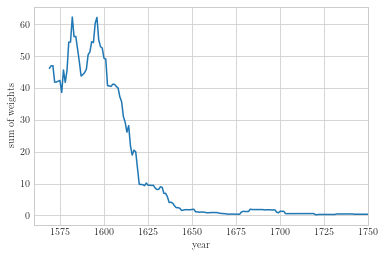

In [17]:
final_topics.groupby('year')['topic 9'].sum().rolling(window=20).mean().plot()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
#plt.legend(['9: religion and old spelling'], loc='right', bbox_to_anchor=(1.5, 0.75),
          #ncol=1, fancybox=False, shadow=False)
#plt.title('Sum of topic weights ($\geq$ 0.100) of all songs per year: religion and old spelling')
plt.ylabel('sum of weights')
plt.xlabel('year')
plt.xlim([1560, 1750])
#plt.show()
plt.savefig('../plots/Figure4.jpg', bbox_inches='tight', dpi=300)

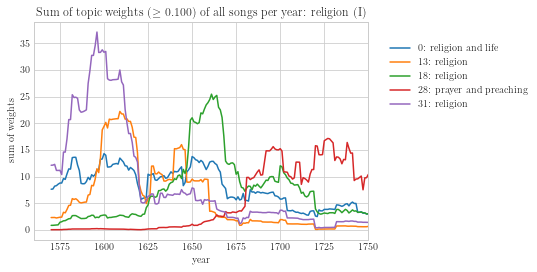

In [310]:
final_topics.groupby('year')['topic 0', 'topic 13', 'topic 18', 'topic 28', 'topic 31'].sum().rolling(window=20).mean().plot()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.legend(['0: religion and life', '13: religion', '18: religion', '28: prayer and preaching', '31: religion'], loc='right', bbox_to_anchor=(1.5, 0.75),
          ncol=1, fancybox=False, shadow=False)
plt.title('Sum of topic weights ($\geq$ 0.100) of all songs per year: religion (I)')
plt.ylabel('sum of weights')
plt.xlabel('year')
plt.xlim([1560, 1750])
#plt.show()
plt.savefig('../plots/religion1.jpg', bbox_inches='tight', dpi=300)

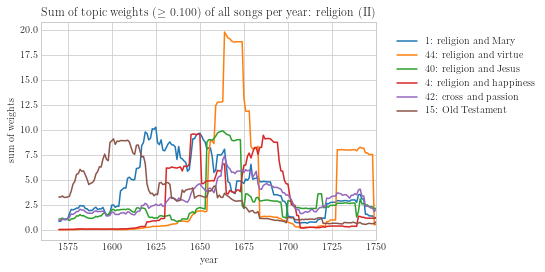

In [311]:
final_topics.groupby('year')['topic 1', 'topic 44', 'topic 40', 'topic 4', 'topic 42', 'topic 15'].sum().rolling(window=20).mean().plot()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.legend(['1: religion and Mary', '44: religion and virtue', '40: religion and Jesus', '4: religion and happiness', '42: cross and passion', '15: Old Testament'], loc='right', bbox_to_anchor=(1.5, 0.75),
          ncol=1, fancybox=False, shadow=False)
plt.title('Sum of topic weights ($\geq$ 0.100) of all songs per year: religion (II)')
plt.ylabel('sum of weights')
plt.xlabel('year')
plt.xlim([1560, 1750])
#plt.show()
plt.savefig('../plots/religion2.jpg', bbox_inches='tight', dpi=300)

### Literature and poetics, version 2

/Users/alielassche/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


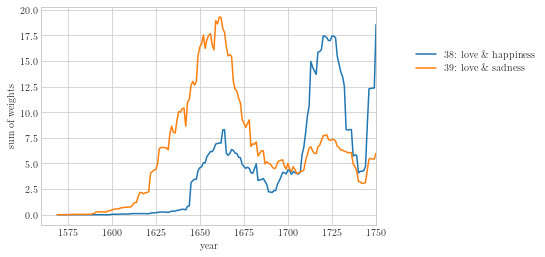

In [21]:
final_topics.groupby('year')['topic 38', 'topic 39'].sum().rolling(window=20).mean().plot()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.legend(['38: love \& happiness', '39: love \& sadness'], loc='right', bbox_to_anchor=(1.5, 0.75),
          ncol=1, fancybox=False, shadow=False)
#plt.title('Sum of topic weights ($\geq$ 0.100) of all songs per year: love (I)')
plt.ylabel('sum of weights')
plt.xlabel('year')
plt.xlim([1560, 1750])
#plt.show()
plt.savefig('../plots/Figure5.jpg', bbox_inches='tight', dpi=300)

/Users/alielassche/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


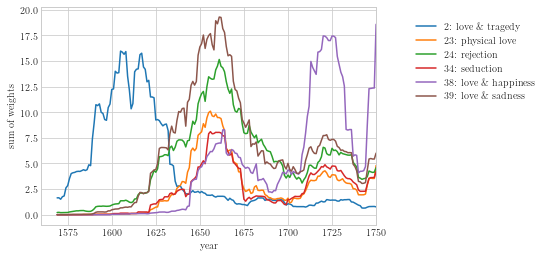

In [28]:
final_topics.groupby('year')['topic 2', 'topic 23', 'topic 24', 'topic 34', 'topic 38', 'topic 39'].sum().rolling(window=20).mean().plot()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.legend(['2: love \& tragedy', '23: physical love', '24: rejection', '34: seduction', '38: love \& happiness', '39: love \& sadness'], loc='right', bbox_to_anchor=(1.5, 0.75),
          ncol=1, fancybox=False, shadow=False)
#plt.title('Sum of topic weights ($\geq$ 0.100) of all songs per year: love (II)')
plt.ylabel('sum of weights')
plt.xlabel('year')
plt.xlim([1560, 1750])
#plt.show()
plt.savefig('../plots/Figure6.jpg', bbox_inches='tight', dpi=300)

/Users/alielassche/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


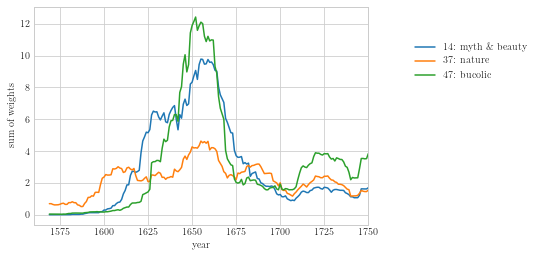

In [25]:
final_topics.groupby('year')['topic 14', 'topic 37', 'topic 47'].sum().rolling(window=20).mean().plot()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.legend(['14: myth \& beauty', '37: nature', '47: bucolic'], loc='right', bbox_to_anchor=(1.5, 0.75),
          ncol=1, fancybox=False, shadow=False)
#plt.title('Sum of topic weights ($\geq$ 0.100) of all songs per year: love (III)')
plt.ylabel('sum of weights')
plt.xlabel('year')
plt.xlim([1560, 1750])
#plt.show()
plt.savefig('../plots/Figure7.jpg', bbox_inches='tight', dpi=300)

/Users/alielassche/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


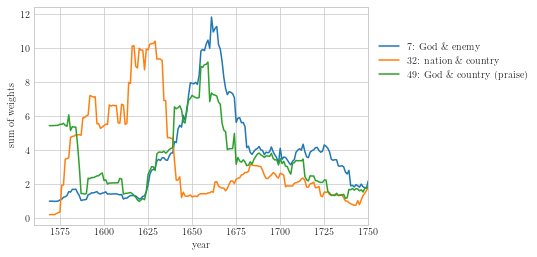

In [29]:
final_topics.groupby('year')['topic 7', 'topic 32', 'topic 49'].sum().rolling(window=20).mean().plot()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.legend(['7: God \& enemy', '32: nation \& country', '49: God \& country (praise)'], loc='right', bbox_to_anchor=(1.5, 0.75),
          ncol=1, fancybox=False, shadow=False)
#plt.title('Sum of topic weights ($\geq$ 0.100) of all songs per year: politics')
plt.ylabel('sum of weights')
plt.xlabel('year')
plt.xlim([1560, 1750])
#plt.show()
plt.savefig('../plots/Figure8.jpg', bbox_inches='tight', dpi=300)

# Roles of literature

In [13]:
df = pd.read_csv('../gensim_output/top3topics_allsongs.csv', sep='\t', index_col=0)

## Literature and ideology

In [14]:
df['top1'] = df['top1'].replace('topic 0', 'religion and life (0)')
df['top1'] = df['top1'].replace('topic 13', 'religion (13)')
df['top1'] = df['top1'].replace('topic 18', 'religion (18)')
df['top1'] = df['top1'].replace('topic 28', 'prayer and preaching (28)')
df['top1'] = df['top1'].replace('topic 31', 'religion (31)')

In [15]:
religion = ['religion and life (0)','religion (13)','religion (18)','prayer and preaching (28)','religion (31)']

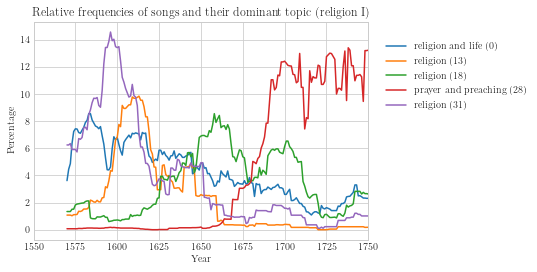

In [17]:
fig2 = pd.crosstab(df.year, df.top1, normalize='index').rolling(window=20).mean()[religion].mul(100).plot()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.legend(loc='right', bbox_to_anchor=(1.5, 0.75),
          ncol=1, fancybox=False, shadow=False)
plt.title('Relative frequencies of songs and their dominant topic (religion I)')
plt.ylabel('Percentage')
plt.xlabel('Year')
plt.savefig('religion_normalized_index.jpg', bbox_inches='tight', dpi=300)

In [18]:
df['top1'] = df['top1'].replace('topic 1', 'religion and Mary (1)')
df['top1'] = df['top1'].replace('topic 44', 'religion and virtue (44)')
df['top1'] = df['top1'].replace('topic 40', 'religion and Jesus (40)')
df['top1'] = df['top1'].replace('topic 4', 'religion and happiness (4)')
df['top1'] = df['top1'].replace('topic 42', 'cross and passion (42)')
df['top1'] = df['top1'].replace('topic 15', 'Old Testament (15)')

In [19]:
religion2  = ['religion and Mary (1)','religion and virtue (44)','religion and Jesus (40)','religion and happiness (4)','cross and passion (42)','Old Testament (15)']

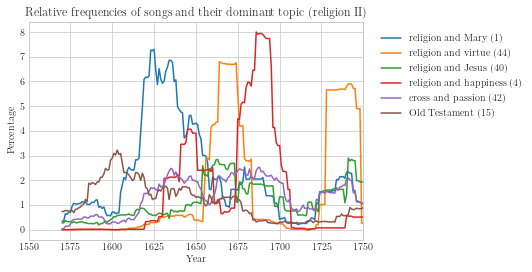

In [21]:
fig1 = pd.crosstab(df.year, df.top1,normalize='index').rolling(window=20).mean()[religion2].mul(100).plot()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.legend(loc='right', bbox_to_anchor=(1.5, 0.75),
          ncol=1, fancybox=False, shadow=False)
plt.title('Relative frequencies of songs and their dominant topic (religion II)')
plt.ylabel('Percentage')
plt.xlabel('Year')
plt.savefig('religion2_normalized_index.jpg', bbox_inches='tight',dpi=300)

## Literature and poetics

In [22]:
df['top1'] = df['top1'].replace('topic 38', 'love and happiness (38)')
df['top1'] = df['top1'].replace('topic 39', 'love and sadness (39)')

In [23]:
love = ['love and happiness (38)','love and sadness (39)']

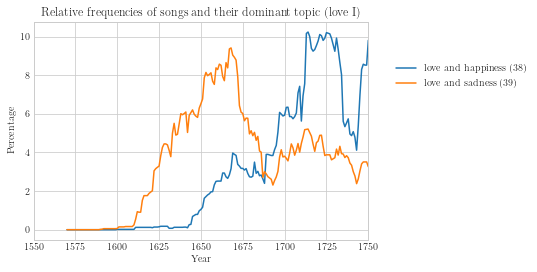

In [25]:
fig1 = pd.crosstab(df.year, df.top1, normalize='index').rolling(window=20).mean()[love].mul(100).plot()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.legend(loc='right', bbox_to_anchor=(1.5, 0.75),
          ncol=1, fancybox=False, shadow=False)
plt.title('Relative frequencies of songs and their dominant topic (love I)')
plt.ylabel('Percentage')
plt.xlabel('Year')
plt.savefig('love_normalized_index.jpg', bbox_inches='tight',dpi=300)

In [26]:
df['top1'] = df['top1'].replace('topic 38', 'love and happiness (38)')
df['top1'] = df['top1'].replace('topic 39', 'love and sadness (39)')
df['top1'] = df['top1'].replace('topic 2', 'love and tragedy (2)')
df['top1'] = df['top1'].replace('topic 24', 'rejection (24)')
df['top1'] = df['top1'].replace('topic 34', 'seducing (34)')
df['top1'] = df['top1'].replace('topic 21', 'love and happiness (21)')
df['top1'] = df['top1'].replace('topic 23', 'physical love (23)')

In [27]:
love_extended = ['love and happiness (38)','love and sadness (39)','love and tragedy (2)','rejection (24)','seducing (34)','love and happiness (21)','physical love (23)']

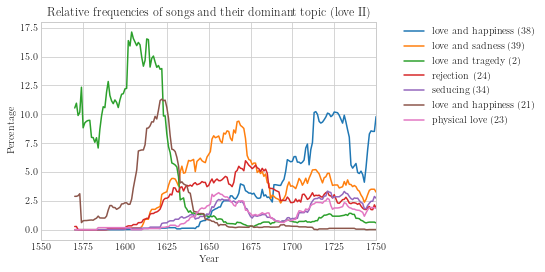

In [29]:
fig1 = pd.crosstab(df.year, df.top1,normalize='index').rolling(window=20).mean()[love_extended].mul(100).plot()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.legend(loc='right', bbox_to_anchor=(1.5, 0.75),
          ncol=1, fancybox=False, shadow=False)
plt.title('Relative frequencies of songs and their dominant topic (love II)')
plt.ylabel('Percentage')
plt.xlabel('Year')
plt.savefig('love_extended_normalized_index.jpg', bbox_inches='tight',dpi=300)

In [30]:
df['top1'] = df['top1'].replace('topic 47', 'bucolic songs (47)')
df['top1'] = df['top1'].replace('topic 14', 'myth and beauty (14)')
df['top1'] = df['top1'].replace('topic 37', 'nature (37)')

In [31]:
bucolic = ['bucolic songs (47)','myth and beauty (14)','nature (37)']

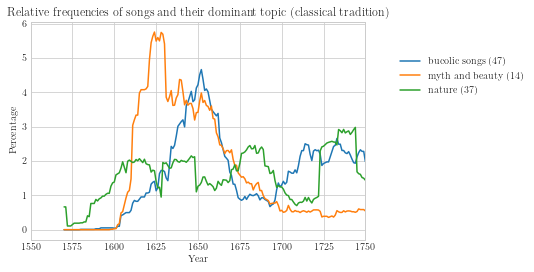

In [33]:
fig1 = pd.crosstab(df.year, df.top1,normalize='index').rolling(window=20).mean()[bucolic].mul(100).plot()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.legend(loc='right', bbox_to_anchor=(1.5, 0.75),
          ncol=1, fancybox=False, shadow=False)
plt.title('Relative frequencies of songs and their dominant topic (classical tradition)')
plt.ylabel('Percentage')
plt.xlabel('Year')
plt.savefig('bucolic_normalized.jpg', bbox_inches='tight',dpi=300)

## Literature and politics

In [34]:
df['top1'] = df['top1'].replace('topic 32', 'nation and country (32)')
df['top1'] = df['top1'].replace('topic 7', 'God and enemy (7)')
df['top1'] = df['top1'].replace('topic 49', 'God and country (49)')

In [35]:
nation = ['nation and country (32)','God and enemy (7)','God and country (49)']

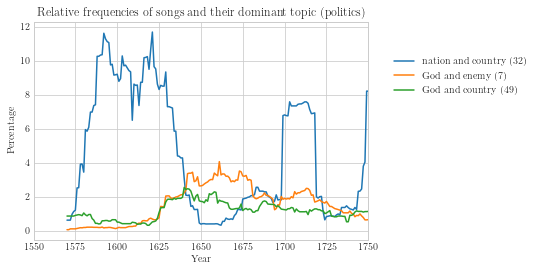

In [37]:
fig1 = pd.crosstab(df.year, df.top1,normalize='index').rolling(window=20).mean()[nation].mul(100).plot()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.legend(loc='right', bbox_to_anchor=(1.5, 0.75),
          ncol=1, fancybox=False, shadow=False)
plt.title('Relative frequencies of songs and their dominant topic (politics)')
plt.ylabel('Percentage')
plt.xlabel('Year')
plt.savefig('nation_normalized.jpg', bbox_inches='tight',dpi=300)